In [1]:
import os
import librosa as liro
import librosa.display as lirod
import matplotlib
from matplotlib import pyplot as plt
import IPython.display as ipd
import torch 
import torch.nn as nn
import torchaudio
from scipy.fft import rfft, rfftfreq
import numpy as np

wd = os.getcwd()
os.chdir(os.path.join(wd, ".."))

from models.mel import AugmentMelSTFT
from datasets import audiodataset

os.chdir(wd)

example_data_path = os.path.join("..", "datasets", "example_data", "audio")
example_file = os.path.join(example_data_path, "dog_bark.wav")

import matplotlib.pyplot as plt
import numpy as np

def plot_spectrogram(mel_specgram_db, waveform, sample_rate):
    num_frames = mel_specgram_db.shape[-1]
    duration = len(waveform[0]) / sample_rate
    num_mel_bins = mel_specgram_db.shape[1]

    plt.figure(figsize=(12, 4))  # wider, less tall
    plt.imshow(
        mel_specgram_db[0].numpy(),
        cmap='magma',
        origin='lower',
        aspect='auto',
        extent=[0, duration, 0, num_mel_bins]
    )
    plt.colorbar(label='dB')
    plt.xlabel('Time [s]')
    plt.ylabel('Mel Bin')
    plt.title('Log Mel Spectrogram')
    plt.tight_layout()
    plt.show()

def wav_plot(x, sr, listen=True, title=""):
    fig, ax = plt.subplots(nrows=1, figsize=(10, 2))
    ax.set_title(title)
    lirod.waveshow(x, sr=sr, ax=ax, axis='s')
    plt.show()
    if listen:
        audio = ipd.Audio(x, rate=sr)
        ipd.display(audio)

# Today's Menu

- **Tips & Tricks for building an ML pipeline**
- **Common Audio Models**
  - CNNs
  - Audio Spectrogram Transformers
- **Your next tasks** 
- **Presentations**

# Are we complete?

* Team Task 1 (Ioan-Cristian, Dominik, Michael, Anna)?
* Team Task 4 (Aleksandr, Fabian, Lara, Maximilian)?
* Team Task 6 (Giovanni, Fabian, Youniss)?
* Team AES: QVIM (Andrei, Anton Atanasov, Aleksandar)?

# Tips & Tricks for building an ML pipeline

## Pipeline - Expectation


<center>
<img src="figs/expectation.jpg" alt="drawing" width="600"/>
</center>

## Pipeline - Reality

<center>
<img src="figs/reality.jpg" alt="drawing" width="600"/>
</center>

## Best Practices for ML Pipelines

- **Document everything**  
  Your future self (and your teammates) should understand *what* you did, *why* you did it, and *how* it works.

- **Double-check your steps**  
  Small mistakes (e.g., data leakage, wrong labels, off-by-one errors) can silently propagate and waste hours later.

- **Log everything**  
  Track parameters, results, errors, and unexpected behaviors. Good logs = easy debugging.

- **Use version control**  
  Commit early, commit often. Track your code *and* configs to understand changes over time.

- **Automate where possible**  
  Make your pipeline reproducible. E.g., use scripts to run multiple commands. 

- **Keep it simple (at first)**  
  Start with a minimal working version, then iterate. Don’t over-engineer early.

## Documentation

- Maintain a continuously updated **work log**  
  Your colleagues (and future you) should be able to quickly understand what you've done and why.

- A good work log saves time when writing your **technical report**  
  You’ll thank yourself later when everything is already written down.

- Store your work log in **version control**  
  Or at least use a shared document if collaborating—keep everything accessible and trackable.

- **Collect questions** for the teaching team in your work log  
  This helps identify common issues and makes discussions more efficient.

- Add comments to your code, focusing on **why** things are done  
  Don't just write *what* the code does—explain the reasoning behind key decisions.

## Version Control

- Use **Git** — it's the standard tool for version control  
  Learn the basics well (commits, branches, merges, resolving conflicts).

- When collaborating, work on your own **branches**  
  This avoids conflicts and allows for parallel development.

- **Merge frequently**  
  Don’t let branches drift too far apart — regular merges help catch issues early.

- Keep the **main/master branch stable and runnable**  
  Treat it as your working baseline; don’t break it.

- Review new features as a **group before merging**  
  Ensure everyone is on the same page and avoid unexpected issues in shared code.

## Testing & Sanity Checks

Run small, regular tests to avoid wasting time debugging later:

- **Exploratory tests**  
  Try out unfamiliar libraries or functions in a Jupyter Notebook to quickly learn how they behave.

- **Sanity checks for your own code**  
  Test functions like data loading, augmentation, or feature extraction on a few samples. Print shapes, min/max, or visualize outputs.

- **Visual inspection**  
  Plot spectrograms, embeddings, or model outputs to ensure your pipeline behaves as expected.

- **Overfit a tiny batch**  
  A classic trick: your model should be able to overfit 1–2 training examples. If it can’t, something’s likely wrong.

- **Group review of key changes**  
  Before running full experiments, verify new code together — four eyes catch more bugs than two.

## Reproducibility: What Can Break It?

- **Code & Dependencies**
  - Changing library versions (e.g., PyTorch, NumPy) can change behavior
  - Solution: use virtual environments (e.g., `conda`, `venv`) and freeze dependencies (`requirements.txt` or `environment.yml`)

- **Training Pipeline**
  - Pseudo-random number generators (PRNGs): Python, NumPy, PyTorch, etc.
  - Parallelism (e.g., multi-GPU, DataLoader workers) can introduce variability
  - Non-deterministic GPU ops (e.g., certain cuDNN kernels, FP16 ops)

- **Data Preprocessing**
  - Augmentations, shuffling, random splits, and label generation must be deterministic
  - Even slight differences (e.g., rounding, file order) can change results

## Reproducibility: How to make deterministic?

```python

if args.SEED is None:
    SEED = secrets.randbelow(2**32)
else:
    SEED = args.SEED
    
# Enforce deterministic ops (optional, slows things down)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

pl.seed_everything(SEED, workers=True) # Let Lightning seed everything, including workers

loader = DataLoader(
    dataset,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED), # Reproducible DataLoader shuffling
    ...
)

log = {"seed": SEED, "git_commit": ..., "torch_version": torch.__version__, ...}
```

## Data Leakage

- **Always use the provided split for your task**  
- Ensure that **no information from the test set leaks** into training or validation. This includes label distribution, normalization stats, data augmentations, etc.
- **Normalization leakage** is a common pitfall: Don’t compute mean/std over the full dataset — only use training data stats.
- Best practice: Treat your test set as **untouchable** — only access it once, at the very end, for final evaluation.


<center>
<img src="figs/leakage.png" alt="drawing" width="600"/>
</center>

## Leakage across devices

* In DCASE Task 1, **recording devices** are a major source of domain shift. 
* Measuring **generalization performance to unseen devices** is crucial.
* Splitting data without considering the recording device causes leakage and may inflate your results. Use the **provided split**, which accounts for device separation.

<center>
<img src="figs/leakage_devices.png" alt="drawing" width="600"/>
</center>

## PyTorch Lightning: Minimal Interface

```python
class MyModel(pl.LightningModule):
    def __init__(self, n_classes=10):
        super().__init__()
        self.model = torch.nn.Linear(128, n_classes)  # example model
        self.validation_step_outputs = []

    def forward(self, x):
        return self.model(x)  # inference step

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        self.validation_step_outputs.append(...)
        return val_loss

    def on_validation_epoch_end(self):
        self.log("val/accuracy", ...)
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

if __name__ == "__main__":
    model = MyModel(n_classes=10)
    train_loader, val_loader = ...  # define DataLoaders
    trainer = pl.Trainer(max_epochs=10)
    trainer.fit(model, train_loader, val_loader)
```

## Weights and Biases: Minimal Interface


```python
def main(config):
    wandb_logger = WandbLogger(
        project="my-project",
        name=config.experiment_name,
        config=vars(config)  # logs all argparse args as W&B config
    )
    
    trainer = pl.Trainer(
        max_epochs=config.n_epochs,
        logger=wandb_logger
    )
    ...

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--n_epochs", type=int, default=10)
    parser.add_argument("--experiment_name", type=str, default="minimal-wandb-run")
    args = parser.parse_args()

    try:
        commit_hash = subprocess.check_output(["git", "rev-parse", "HEAD"]).decode("ascii").strip()
    except Exception:
        commit_hash = "unknown"

    args.commit_hash = commit_hash  # include in logged config

    # save library versions for reproducibility
    args.versions = {
        "torch": torch.__version__,
        ...
    }

    main(args)
```

# Common Audio Models

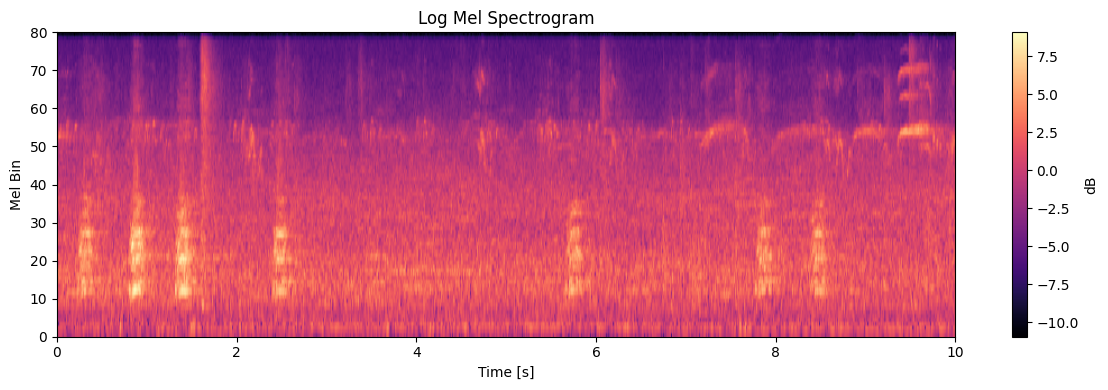

In [2]:
from torchaudio import transforms

waveform, sample_rate = torchaudio.load(example_file)
transform = transforms.MelSpectrogram(sample_rate, n_fft=800, n_mels=80)
mel_specgram = transform(waveform)
log_mel_specgram = torch.log(mel_specgram + 1e-5)
plot_spectrogram(log_mel_specgram, waveform, sample_rate)

What models are commonly used to process spectrograms?

## Convolutional Neural Networks

<center>
<img src="figs/cnn.jpg" alt="drawing" width="800"/>
</center>

Image Source: https://de.mathworks.com/discovery/convolutional-neural-network.html

## Simple CNN in PyTorch

<pre style="font-size: 90%; max-height: 350px; overflow-y: scroll">

Network(
  (in_c): Sequential(
    (0): Conv2d(1, 16, kernel_size=5, stride=2, padding=1)
    (1): BatchNorm2d(16)
    (2): ReLU()
  )
  (features): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 32, kernel_size=3, padding=1)
      (bn1): BatchNorm2d(32)
      (conv2): Conv2d(32, 32, kernel_size=3, padding=1)
      (bn2): BatchNorm2d(32)
      (shortcut): Conv2d(16, 32, kernel_size=1)
    )
    (1): BasicBlock(...)
    (2): MaxPool2d(kernel_size=2, stride=2)
    ...
    (9): BasicBlock(...)
  )
  (feed_forward): Sequential(
    (0): Conv2d(128, 10, kernel_size=1)
    (1): BatchNorm2d(10)
    (2): AdaptiveAvgPool2d(output_size=1)
  )
)
</pre>


## Receptive Field in CNNs

<center>
<img src="figs/receptive_field.png" alt="drawing" width="500"/>
</center>

Image Source: https://www.researchgate.net/figure/The-receptive-field-of-each-convolution-layer-with-a-3-3-kernel-The-green-area-marks_fig4_316950618

## Receptive Field in CNNs

What factors affect the receptive field?

### Formula

Let `r₀ = 1` (input layer), and for each layer `i`:

$$
r_i = r_{i-1} + (k_i - 1) \cdot d_i \cdot \prod_{j=1}^{i-1} s_j
$$

Where:
- `k_i` = kernel size at layer i  
- `s_j` = stride at layer j  
- `d_i` = dilation at layer i

### Receptive Field Example

CNN with 3 layers:

| Layer | Kernel | Stride | Dilation |
|-------|--------|--------|----------|
| 1     | 3      | 2      | 2        |
| 2     | 3      | 1      | 1        |
| 3     | 3      | 1      | 1        |

Start with `r₀ = 1`

- `r₁ = 1 + (3 - 1) × 2 × 1 = 5`  
- `r₂ = 5 + (3 - 1) × 1 × 2 = 9`  
- `r₃ = 9 + (3 - 1) × 1 × 2 = 13`

**Final receptive field**: **13**

## Conv2D for Audio Spectrograms

**Input Tensor**:  
`X ∈ ℝ^(?)`  
(e.g., batch of spectrograms)

**Conv Layer**:  
- Weights: `W ∈ ℝ^(?)`  
- Bias: `b ∈ ℝ^(?)`  
- Stride: `(S_f, S_t)`, Padding: `(P_f, P_t)`

**Output Tensor**:  
`Y ∈ ℝ^(?)`  
where  
`F_out = ⎣(F_in + 2P_f - K_f)/S_f⎦ + 1`  
`T_out = ⎣(T_in + 2P_t - K_t)/S_t⎦ + 1`

**Total Parameters** (excluding bias):  
`?`

**Computational Operations (MACs)** (excluding bias):  
`?`

## Conv2D for Audio Spectrograms

**Input Tensor**:  
`X ∈ ℝ^(B × C_in × F_in × T_in)`  
(e.g., batch of spectrograms)

**Conv Layer**:  
- Weights: `W ∈ ℝ^(C_out × C_in × K_f × K_t)`  
- Bias: `b ∈ ℝ^(C_out)`  
- Stride: `(S_f, S_t)`, Padding: `(P_f, P_t)`

**Output Tensor**:  
`Y ∈ ℝ^(B × C_out × F_out × T_out)`  
where  
`F_out = ⎣(F_in + 2P_f - K_f)/S_f⎦ + 1`  
`T_out = ⎣(T_in + 2P_t - K_t)/S_t⎦ + 1`

**Total Parameters** (excluding bias):  
`C_out × C_in × K_f × K_t`

**Computational Operations (MACs)** (excluding bias):  
`B × C_out × F_out × T_out × C_in × K_f × K_t`

## MobileNetV3 Block (Inverted Residual Block)

<center>
<img src="figs/mobilenetv3_block.png" alt="drawing" width="800"/>
</center>

Image Source: https://arxiv.org/pdf/1905.02244

### Inverted Residual Block (expansion → depthwise → projection)

Let `C_exp = r × C_in` (expansion ratio `r`, e.g., 3)

1. **Pointwise (Expand)**  
   - Params: `C_exp × C_in`  
   - MACs: `B × F × T × C_exp × C_in`

2. **Depthwise (K×K)**  
   - Params: `C_exp × K × K`  
   - MACs: `B × F × T × C_exp × K × K`

3. **Pointwise (Project)**  
   - Params: `C_out × C_exp`  
   - MACs: `B × F × T × C_out × C_exp`

**Total Params**:  
`C_exp × C_in + C_exp × K × K + C_out × C_exp`  
= `r·C_in² + r·C_in·K² + C_out·r·C_in`

**Total MACs**:  
`B × F × T × (r·C_in² + r·C_in·K² + C_out·r·C_in)`

## Parameters Complexity Comparison 

- Assume realistic values: **r=3, K=3x3**

- **Inverted Residual Block**:  
Params = `3·C_in² + 27·C_in + 3·C_in·C_out` = `3·C_in·(C_in + 9 + C_out)`

---

- **Standard 3×3 Conv**:
Params = `9·C_in·C_out`

---

- Assume: `C_in = C_out`:

  - Inverted Residual Block: `3·C_in·(2·C_in + 9)`  
  - Standard Conv: `9·C_in²`

---

**Parameter Ratio**:

$$
\text{Ratio} = \frac{3 \cdot C_{\text{in}} \cdot (2C_{\text{in}} + 9)}{9 \cdot C_{\text{in}}^2} 
= \frac{2C_{\text{in}} + 9}{3C_{\text{in}}} \approx = \frac{2}{3}
$$


## MobileNetV3 Architecture

<center>
<img src="figs/mnv3_architecture.png" alt="drawing" width="500"/>
</center>

Image Source: https://arxiv.org/pdf/1905.02244

Do you know what we need to change *at least* in order to apply MobileNetV3 to an audio task with `n_classes`?

## Audio Spectrogram Transformers



<center>
<img src="figs/transformer.png" alt="drawing" width="400"/>
</center>

Source: https://arxiv.org/abs/1706.03762

## Multi-Head Self-Attention (MHSA)

Input:  
`X ∈ ℝ^{B × N × d_model}`  
(B = batch size, N = sequence length)

---

**Linear Projections (per head `h ∈ {1, ..., H}`):**

$$
Q_h = X W_h^Q,\quad K_h = X W_h^K,\quad V_h = X W_h^V
$$

$$
W_h^Q, W_h^K, W_h^V ∈ ℝ^{d_{model} × d_{head}}
$$

$$
Q_h, K_h, V_h ∈ ℝ^{B × N × d_{head}}
$$


## Scaled Dot-Product Attention (Per Head)

Given:  
$Q_h, K_h, V_h ∈ ℝ^{B × N × d_{head}}$

---

Attention for each head:

$$
\text{Attention}(Q_h, K_h, V_h) =
\text{softmax}\left(\frac{Q_h K_h^\top}{\sqrt{d_{head}}}\right) V_h
$$

Shape details:
- $Q_h K_h^\top$ → $ℝ^{B × N × N}$  
- Softmax applied over the last axis (each query attends to all keys)
- Matrix multiplication with $V_h$ → output is $ℝ^{B × N × d_{head}}$

---

⚠️ **Quadratic Complexity**:  
Computing $Q_h K_h^\top$ involves all pairwise token comparisons →  
**$O(N^2 · d_{head})$** per head, making attention quadratic in sequence length.



## Multi-Head Self-Attention: Output

Each head:
$$
\text{head}_h = \text{Attention}(Q_h, K_h, V_h)
$$

Final output:
$$
\text{MHSA}(X) = \text{Concat}(\text{head}_1, ..., \text{head}_H) W^O
$$
$$
W^O ∈ ℝ^{H·d_{head} × d_{model}}
$$


## Positional Encodings

Transformers have no recurrence or convolution, so they treat inputs as an unordered set.  
**Self-attention is permutation-invariant**, meaning the model lacks any sense of token order.

To address this, **positional encodings** are added to the input embeddings to inject information about **token positions**.

Common choices:
- **Sinusoidal encodings** (fixed)
- **Learned positional embeddings** (trainable)

The input to the transformer becomes:
$z_i = x_i + p_i$


## Audio Spectrogram Transformers

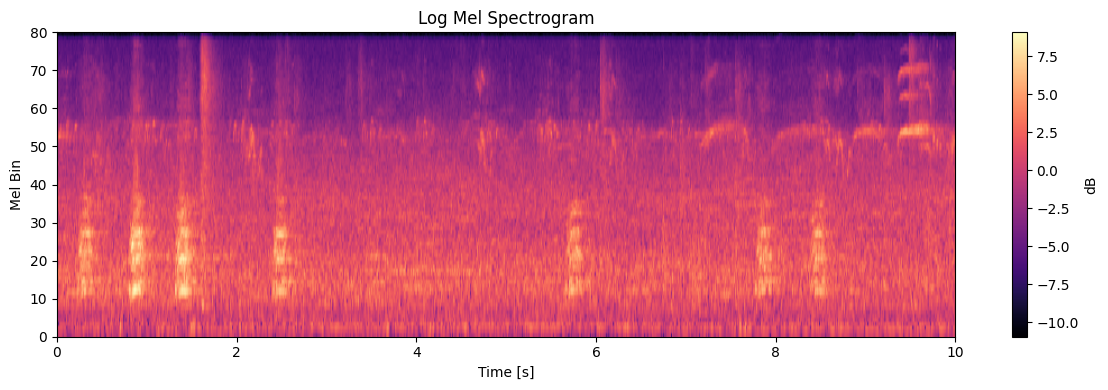

In [21]:
plot_spectrogram(log_mel_specgram, waveform, sample_rate)

How to transform the spectrogram into a sequence of tokens?

Transformer Input:  
`X ∈ ℝ^{B × N × d_model}`  
(B = batch size, N = sequence length)

## Audio Spectrogram Transformers

<center>
<img src="figs/ast.png" alt="drawing" width="500"/>
</center>

Image Source: https://arxiv.org/pdf/2104.01778

## Audio Spectrogram Transformers

<center>
<img src="figs/ast_frontend.png" alt="drawing" width="500"/>
</center>

```python
patch_size, stride = (16, 16), (10, 10)
d_model = 768
patch_embed = nn.Conv2d(1, d_model, kernel_size=patch_size, stride=stride)
spectrogram = ... # shape: B x 1 x F x T
patches = patch_embed(spectrogram) # shape: B x d_model x F_out x T_out
sequence = patches.flatten(dim=2).transpose(1, 2) # shape: B x N x d_model
```

## CNNs vs. Transformers

| Aspect              | CNNs                                              | Transformers                                          |
|---------------------|---------------------------------------------------|--------------------------------------------------------|
| **Inductive Bias**  | Locality, shift-invariance                        | No spatial bias, models all pairwise interactions     |
| **Strengths**       | Efficient, low-latency, strong for local patterns | Global context, long-range dependencies, flexible     |
| **Weaknesses**      | Limited receptive field growth                    | Quadratic complexity (O(N²)), data-hungry             |
| **Computational Cost** | Linear in input size                         | Quadratic in sequence length                          |
| **Use Cases**       | real-time applications, early layers     | Language, audio, vision, global interaction     |
| **Pretraining**     | Less dominant in large-scale pretraining         | Strong foundation models (e.g., BERT, ViT, BEATs)     |

**Summary**:  
Use **CNNs** when locality and efficiency matter.  
Use **Transformers** when modeling global context is key.

## Pre-Trained Audio Models

Pre-trained models are trained on large-scale audio datasets (e.g., AudioSet) using significant compute and time.

**Why use them?**
- Encode **general knowledge** about audio structure, events, and semantics
- Learn from **millions of unlabeled or weakly labeled clips**
- Extract powerful, reusable **representations** from raw waveforms or spectrograms


**Benefits for Downstream Tasks**:
- Require **less labeled data**
- Achieve **higher accuracy**, especially in low-data regimes

You’ll mostly **fine-tune or adapt** these models instead of training from scratch.

## AudioSet

**AudioSet** is the largest general-purpose dataset for sound classification.

- Over **2 million** 10-second audio clips sourced from **YouTube videos**
- Each clip is **weakly labeled** (labels apply to the whole clip, no timestamps)
- Covers **527 sound classes** organized in a **hierarchical ontology** to organize classes (e.g., "Vehicle" → "Car" → "Car engine")

<center>
<img src="figs/audioset.png" alt="drawing" width="400"/>
</center>

**Use Cases**:
- Pre-training for audio tagging, event detection, representation learning
- Common benchmark for large-scale audio models

AudioSet: https://research.google.com/audioset/

## Patchout faSt Spectrogram Transformer (PaSST)

<center>
<img src="figs/passt.png" alt="drawing" width="500"/>
</center>

- Pre-Trained on ImageNet and AudioSet
- Introduced *Patchout* mechanism

Github: https://github.com/kkoutini/PaSST?tab=readme-ov-file | Paper: https://arxiv.org/abs/2110.05069

## Pre-Trained MobileNetV3

<center>
<img src="figs/mn_kd.png" alt="drawing" width="800"/>
</center>

- Pre-Trained on ImageNet, then on AudioSet with Knowledge Distillation
- Matches PaSST performance with *much* less compute and parameters

Github: https://github.com/fschmid56/EfficientAT | Paper: https://arxiv.org/pdf/2211.04772

## How to use pre-trained models for your task?

Output (batch size dimension ommitted):
- CNN: ```C x F x T``` (channels, frequency bins, time frames of feature map)
- Transformer: ```N x C``` (sequence length, channels/embedding dimension)
  
Based on your task, you may require:
- **Global Embeddings** (one vector per audio clip)
  - CNN:
    - Average over spatial dimensions (`F` and `T`) $\rightarrow$ vector of size `C`
  - Transformer:
    - Average over sequence (`N`) $\rightarrow$ vector of size `C`
    - Select special global token (see *C* and *D* tokens for PaSST)

## How to use pre-trained models for your task?

Output (batch size dimension ommitted):
- CNN: ```C x F x T``` (channels, frequency bins, time frames of feature map)
- Transformer: ```N x C``` (sequence length, channels/embedding dimension)
  
Based on your task, you may require:
- **Clip-Wise Predictions** (global predictions, one label per audio clip)
  - Use **global embeddings** (see last side)
  - Add a **prediction head** (e.g., a linear layer of shape `C x n_classes`)

## How to use pre-trained models for your task?

Output (batch size dimension ommitted):
- CNN: ```C x F x T``` (channels, frequency bins, time frames of feature map)
- Transformer: ```N x C``` (sequence length, channels/embedding dimension)
  
Based on your task, you may require:
- **Sequence of Embeddings** (feature vectors over time)
  - CNN:
    - Average over frequency (`F`), then transpose → `T × C`
    - Alternatively: design CNN with `F = 1`, then squeeze and transpose → `T × C`
  - Transformer:
    - Use output directly: ```N x C```

## How to use pre-trained models for your task?

Output (batch size dimension ommitted):
- CNN: ```C x F x T``` (channels, frequency bins, time frames of feature map)
- Transformer: ```N x C``` (sequence length, channels/embedding dimension)
  
Based on your task, you may require:
- **Sequence of Predictions** (predictions at a specific temporal resolution)
  - Start from a **sequence of embeddings** (see previous slide)
  - Attach a **prediction head**:
    - Linear layer applied at each timestep: `C × n_classes` → applied to each `T` (CNN) or `N` (Transformer)
    - Optionally: add an **RNN** on top to model specific temporal dynamics of your task

## How to use pre-trained models for your task?

Output (batch size dimension ommitted):
- CNN: ```C x F x T``` (channels, frequency bins, time frames of feature map)
- Transformer: ```N x C``` (sequence length, channels/embedding dimension)
  

Depending on your task and data size, you may:

- **Fine-tune the pre-trained model end-to-end**  
  - Gradients are propagated through the pre-trained model  
  - Model weights are updated during training

- **Keep the pre-trained model frozen**  
  - Only the task-specific layers are trained  
  - No gradient updates to the pre-trained backbone

**Important:**  
Always **match the exact audio preprocessing** (e.g., sample rate, log-mel config) of the pre-trained model you are using!

# Audio Signal Processing

## Audio Signal Processing

### Disclaimer:

The following section is a **practical introduction** to audio signal processing for deep learning. It is meant to help you:

- **Understand** common steps and **hyperparameters** used in audio pipelines
- **Interpret preprocessing choices** in research papers and codebases

What this **is not**:

- A deep dive into the mathematical theory behind signal processing  
- A substitute for a full course on digital signal processing (DSP)

If you're curious to go deeper into the math, we highly recommend  
📘 [The Scientist and Engineer's Guide to Digital Signal Processing](https://www.dspguide.com/)

## Overview – Theory

Let's do a speedrun across the theoretical foundations of a typical audio signal processing pipeline:

- **Sound and Digital Audio Signals**: What is sound, and how do we convert it into a digital signal?
- **Digital Filters**: Tools to process the digital signal in time or frequency domain
- **Discrete Fourier Transform (DFT)**: Analyze a digital signal in terms of its frequency components
- **Magnitude Spectrum**: Convert the complex spectrum into a magnitude spectrum
- **Frequency Resolution**: Understand the frequency spacing and resolution of the spectrum
- **Spectral Leakage and Windowing**: Use window functions to reduce spectral leakage
- **Short-Time Fourier Transform (STFT)**: Convert a time-domain signal into a time–frequency representation
- **Mel Transform**: Compress the frequency axis based on human auditory perception
- **Logarithmic Compression of Amplitude**: Compress the dynamic range → **log mel spectrogram**

## An example

Our starting point: ... a dog barking

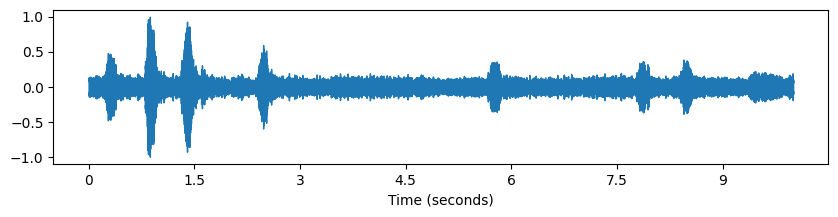

In [3]:
sr = 32000 
example_wav, _ = liro.load(example_file, sr=sr)
wav_plot(example_wav, sr)

## Long Story Short

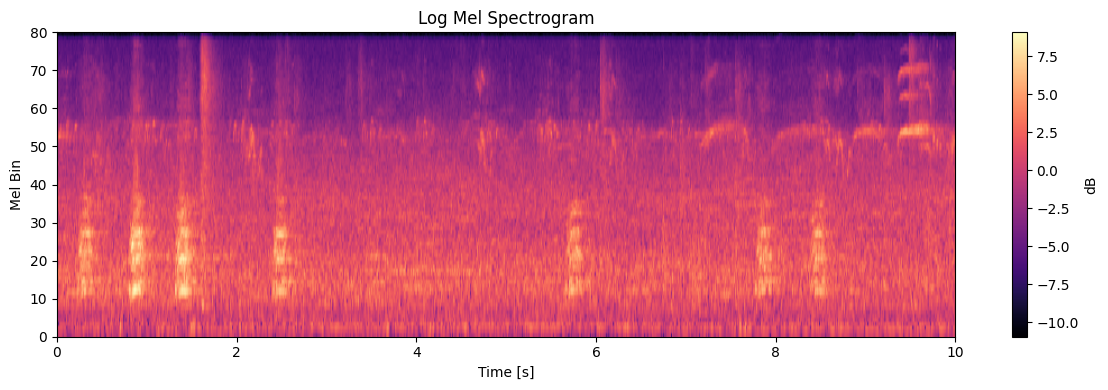

In [4]:
from torchaudio import transforms

waveform, sample_rate = torchaudio.load(example_file)
transform = transforms.MelSpectrogram(sample_rate, n_fft=800, n_mels=80)
mel_specgram = transform(waveform)
log_mel_specgram = torch.log(mel_specgram + 1e-5)
plot_spectrogram(log_mel_specgram, waveform, sample_rate)

## Sound and Digital Audio Signals

* **Sound**: variation in air pressure at a point in space as a function of time
* The microphone turns the mechanical energy of a soundwave into an analog electrical signal
* To process it with a computer, we convert it into a **digital signal**, which involves:
  - Any ideas?

## Sound and Digital Audio Signals

* **Sound**: variation in air pressure at a point in space as a function of time
* The microphone turns the mechanical energy of a soundwave into an analog electrical signal
* To process it with a computer, we convert it into a **digital signal**, which involves:
  - **Sampling**: measuring the signal at regular time intervals (**sampling rate**, e.g., 44,100 times per second)
  - **Quantization**: rounding each sample to a fixed set of amplitude levels (**bit depth**, e.g., 16-bit resolution)



<center>
<img src="figs/digitized_signal.png" alt="drawing" width="300"/>
</center>

## The Sampling Theorem

- If the signal is "**properly sampled**", it can be **reconstructed exactly** from its samples
- A continuous (analog) signal is "**properly sampled**" if it contains **no frequency components above half the sampling rate**
  - This limit is called the **Nyquist frequency**
  - Example: for a sampling rate of 44,100 Hz → Nyquist frequency = 22,050 Hz

- Frequencies **above the Nyquist limit** will be **aliased** — incorrectly folded into lower frequencies:
  → results in **distortion** and **irrecoverable information loss**

- To prevent aliasing: Apply an **analog low-pass filter** before digitizing the signal

## The Sampling Theorem

<center>
<img src="figs/sampling_theorem.png" alt="drawing" width="700"/>
</center>

## Digital Filters

- Digital filters are essential tools in audio processing  
  → used to enhance, suppress, or separate signal components

- Can operate in the **time** or **frequency domain**
- Defined by their **impulse response** or **frequency response**

- Two main types:
  - **FIR (Finite Impulse Response)** → implemented via convolution
  - **IIR (Infinite Impulse Response)** → uses recursion (feedback)

See the **pre-emphasis filter** in the example pipeline


## Discrete Fourier Transform (DFT)

- The DFT can be used to analyze digital signals in terms of their **frequency components**
- It assumes the signal is **finite, periodic**, and **repeats infinitely** in both directions
- The result is a set of **complex coefficients**, each representing a sinusoidal basis function:

$$
X[k] = \frac{1}{N} \sum_{n=0}^{N-1} x[n] \cdot e^{\frac{-2\pi i k n}{N}}
$$

- $x[n]$: time domain signal
- $X[k]$: complex amplitude of the $k$-th frequency bin  
- $N$: number of time samples  
- The exponent represents a **complex sinusoid** (a rotating vector)



## Discrete Fourier Transform (DFT)

Using Euler’s formula:

$$
e^{ix} = \cos(x) + i \sin(x)
$$

we can write:

$$
X[k] = \frac{1}{N} \sum_{n=0}^{N-1} x[n] \cdot \cos\left(\frac{-2\pi k n}{N}\right)
+ i \cdot x[n] \cdot \sin\left(\frac{-2\pi k n}{N}\right)
$$

- The **real part** corresponds to how much of a **cosine wave** (frequency $k$) is present in the signal  
- The **imaginary part** corresponds to how much of a **sine wave** (same frequency $k$) is present  

$\rightarrow$ The DFT tells us **how much of each sine and cosine wave at frequency $k$** is needed to reconstruct the signal.

## Discrete Fourier Transform (DFT)

Basis functions for 16-point DFT:

<center>
<img src="figs/basis.png" alt="drawing" width="400"/>
</center>

## Discrete Fourier Transform (DFT)

* The time-domain signal consists of $N$ samples: $x[0] \dots x[N-1]$
* The DFT translates this into $\frac{N}{2} + 1$ sine (imaginary) and cosine (real) amplitudes
* The DFT can be computed via:
  - **Matrix multiplication** with sine/cosine basis → $O(N^2)$
  - Or much faster using the **Fast Fourier Transform (FFT)** → $O(N \log N)$

<center>
<img src="figs/DFT.png" alt="drawing" width="500"/>
</center>

## Magnitude Spectrum

- Each DFT coefficient $X[k]$ is a **complex number** with a **real part** (cosine component) and an **imaginary part** (sine component)

- These can be converted to **polar form**:
  - **Magnitude**:  $ |X[k]| = \sqrt{(\mathrm{Re}\,X[k])^2 + (\mathrm{Im}\,X[k])^2} $
  - **Phase** (angle): $ \phi[k] = \arctan2(\mathrm{Im}\,X[k], \mathrm{Re}\,X[k]) $

<center>
<img src="figs/mag_phase.png" alt="drawing" width="400"/>
</center>


## Magnitude Spectrum

- The **magnitude** of bin $X[k]$ reflects how much **energy** is present in its frequency band
- In many applications:
  - We use only the **magnitude spectrum**— or more often, the **power spectrum** (squared magnitude)
  - The **phase** is often ignored — the human ear is mostly **insensitive to phase**, except in some edge cases (e.g., localization, transients)

<center>
<img src="figs/mag_phase.png" alt="drawing" width="400"/>
</center>

## Frequency Resolution

* An $N$-point FFT (typically with $N$ as a power of 2) produces $\frac{N}{2} + 1$ frequency bins for real-valued input
* These bins are **uniformly spaced** from $0$ to $\frac{S}{2}$ Hz, where $S$ is the **sampling rate**
* The **frequency spacing between bins** is: $\Delta f = \dfrac{\frac{S}{2}}{\frac{N}{2} + 1} \approx \frac{S}{N}$
→ This is often called the **frequency resolution**

### Example:
- Sampling rate: $S = 32,000$ Hz  
- FFT size: $N = 1024$

$$\Delta f \approx \frac{32000}{1024} \approx 31.25\ \text{Hz}$$

→ You get **513 bins**, each representing a frequency band ~31.25 Hz wide, from **0 Hz up to 16,000 Hz**

## Frequency Resolution

- To get more finely spaced bins in the frequency domain:
  - You can **increase $N$ by zero-padding** the signal (appending zeros)
  - This improves **visual resolution**, but not **true spectral resolution**

<center>
<img src="figs/zero_padding.png" alt="drawing" width="600"/>
</center>

## Spectral Leakage and Windowing

- The DFT assumes the signal is **periodic** over the analysis window  
  → It treats the time-domain signal as if it's **infinitely repeated**

<center>
<img src="figs/signal_repeated.png" alt="drawing" width="800"/>
</center>

- If a sinusoid does **not complete an integer number of cycles** within the window:
  - It gets **cut off at the edges**
  - This introduces **discontinuities** at the window boundaries

## Spectral Leakage and Windowing

- These sharp edges cause **spectral leakage**:
  - Energy from a single frequency spreads into **many DFT bins**
  - This effect requires **many basis functions** to explain the edge artifacts

<center>
<img src="figs/spectral_leakage.png" alt="drawing" width="400"/>
</center>

- To reduce discontinuities at the window edges, we **multiply the signal with a window function**
  → This **smoothly tapers** the signal to zero at the edges  
  → Prevents sharp "cuts" that cause spectral leakage

## Spectral Leakage and Windowing

- With proper windowing, sine waves that **don’t perfectly align with DFT bins** produce **cleaner, more localized peaks**

- Common window functions:
  - **Hann**, **Hamming**, **Blackman**, **Gaussian**, etc.

- There’s a **trade-off** between **narrow peak** and **low side lobes**

<center>
<img src="figs/windowing.png" alt="drawing" width="600"/>
</center>

## Short-Time Fourier Transform (STFT)

- A regular DFT tells us **nothing about when** things happen
- The **Short-Time Fourier Transform** (STFT) computes a **time–frequency representation** (spectrogram) by:
  - Splitting the signal into **short, overlapping windows**
  - Computing the **DFT separately for each window**

<center>
<img src="figs/stft.png" alt="drawing" width="400"/>
</center>

## Short-Time Fourier Transform (STFT)

- Choose your **window length** wisely:
  - Why?
 
<center>
<img src="figs/stft.png" alt="drawing" width="400"/>
</center>

## Short-Time Fourier Transform (STFT)

- Choose your **window length** wisely:
  - Long window → better frequency resolution, worse time resolution
  - Short window → better time resolution, worse frequency resolution
  - Use a length where the signal is approximately **stationary** within a window
 
<center>
<img src="figs/stft.png" alt="drawing" width="400"/>
</center>

## Mel Transform

- After computing the **STFT**, we usually apply a **Mel filterbank** to transform the linear frequency spectrogram into a **perceptually motivated, compressed representation**

- Motivation from human perception: The human ear **does not perceive frequency linearly**. We are **more sensitive to changes** in **low frequencies** than in **high frequencies**.
  
- This can be implemented as a **matrix multiplication**:  
  $$
  \mathrm{mel\_spec} = \mathrm{torch.matmul}(\mathrm{mel\_filterbank}, \mathrm{spectrogram})
  $$  

- Purpose:
  - **Reduce dimensionality** of the spectrogram
  - **Emphasize features** most relevant to human hearing



## Mel Filterbank

<center>
<img src="figs/mel_filterbank.png" alt="drawing" width="600"/>
</center>

## Logarithmic Compression of Amplitude

- The human ear **does not perceive loudness linearly**:
  - A **10× increase in sound power** results in approximately a **2× increase in perceived loudness**
  - This follows a **power-law relationship**: $ \text{Loudness} \propto \text{Power}^n $, with $ n \approx 0.3 $ 
  - To handle the wide dynamic range of real-world sounds, we use a **logarithmic scale** — the **decibel (dB)** scale — which aligns well with human perception

- To convert **sound power** \( P \) to **decibels**:
  $$
  \text{dB} = 10 \cdot \log_{10}\left(\frac{P}{P_{\text{ref}}}\right)
  $$

In [5]:
def freq_plot(x, sr, title="", n=1024, log_freq=True):
    x_mag = np.abs(rfft(x, n=n))
    x_mag = liro.amplitude_to_db(x_mag)
    freqs = rfftfreq(n, 1 / sr)
    fig, ax = plt.subplots(nrows=1, figsize=(10, 2))
    ax.set_title(title)
    if log_freq:
        ax.plot(freqs, x_mag)
        ax.set_xscale('symlog', base=2)
    else:
        ax.plot(x_mag)
    ax.set_xlabel("Frequency (Hertz)")
    ax.set_ylabel("Amplitude (dB)")
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.show()

In [6]:
def spec_liro(x, sr, n_fft=1024, win_length=800, hop_length=320, x_is_spec=False,
              x_is_power_spec=False, x_is_mel_spec=False, convert_to_db=True, title="Spectrogram"):
    import matplotlib.pyplot as plt
    import librosa.display as lirod

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(title)

    if x_is_mel_spec:
        x_is_power_spec = True
        x_is_spec = True
    if x_is_power_spec:
        x_is_spec = True

    # If input is waveform, compute magnitude spectrogram
    if not x_is_spec:
        x = liro.stft(x, n_fft=n_fft, win_length=win_length, hop_length=hop_length)
        x = np.abs(x)  # magnitude

    # Convert to dB
    if convert_to_db:
        if x_is_power_spec:
            x = liro.power_to_db(x)
        else:
            x = liro.amplitude_to_db(x)

    # Display spectrogram with correct time axis
    img = lirod.specshow(
        x,
        sr=sr,
        hop_length=hop_length,
        x_axis='time',
        y_axis='mel' if x_is_mel_spec else 'log',
        cmap='magma',
        ax=ax,
        n_fft=n_fft,
        win_length=win_length
    )

    fig.colorbar(img, ax=ax, format='%+2.0f dB' if convert_to_db else None)
    plt.tight_layout()
    plt.show()

## Overview - Practical Example

Let's look at a typical preprocessing pipeline (see [example pipeline on GitHub](https://github.com/fschmid56/malach24)):

- **Pre-emphasis filter**: a simple FIR filter applied in the time domain to amplify high frequencies and flatten the spectrum
- **Short-Time Fourier Transform (STFT)**
- **Power spectrogram**: compute the squared magnitude of the complex STFT
- **Mel Transform**
- **Logarithmic Amplitude compression** → **log mel spectrogram**

## An Example: from the waveform to the log mel spectrogram

Our starting point: ... a dog barking

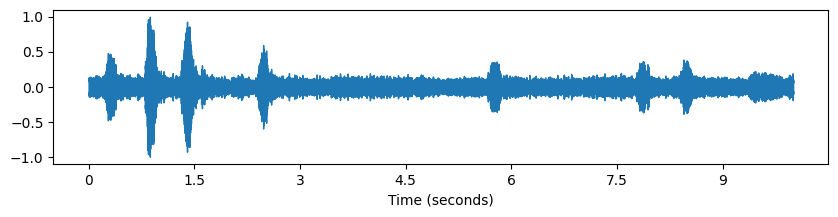

In [7]:
sr = 32000 
example_wav, _ = liro.load(example_file, sr=sr)
wav_plot(example_wav, sr)

## Apply Pre-emphasis (Digital Filter)

- In natural audio signals, **low frequencies tend to dominate**, with energy typically **dropping ~2 dB per kHz**
- This spectral imbalance can **mask important details** in higher frequencies

- A **pre-emphasis filter** is a simple **FIR (Finite Impulse Response)** filter applied in the time domain to:
  - Flatten the spectral envelope
  - Boost higher frequencies

## Apply Pre-emphasis (Digital Filter)

In [8]:
preemphasis_coefficient = torch.as_tensor([[[-.97, 1]]])
wav_torch = torch.from_numpy(example_wav)
wav_pree = nn.functional.conv1d(wav_torch.reshape(1, 1, -1), 
                                preemphasis_coefficient).squeeze(1)

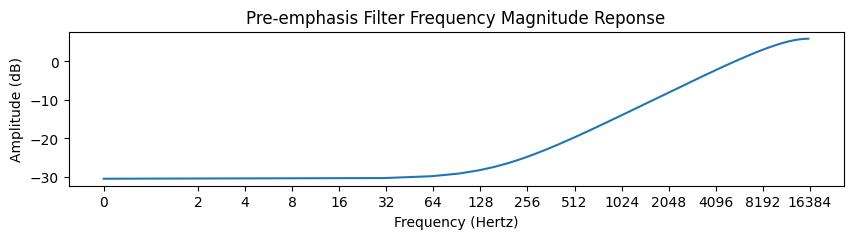

In [9]:
freq_plot(preemphasis_coefficient.squeeze().numpy(), sr, title="Pre-emphasis Filter Frequency Magnitude Reponse")

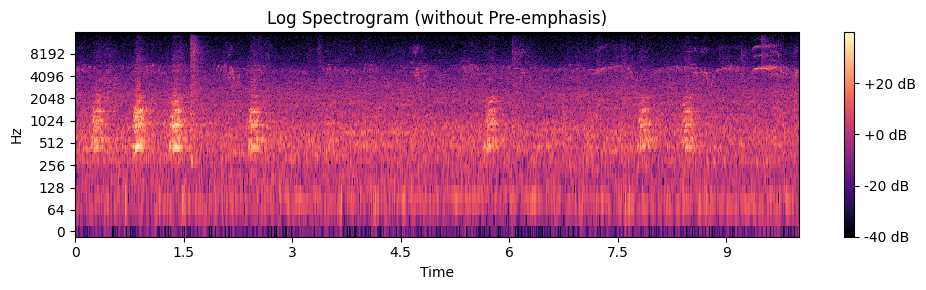

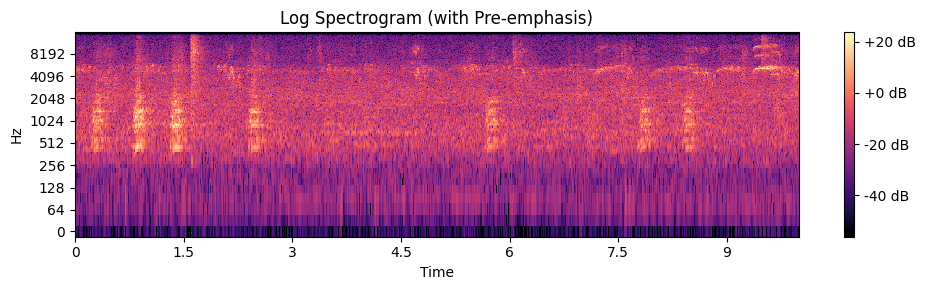

In [10]:
spec_liro(example_wav, sr, title="Log Spectrogram (without Pre-emphasis)")
spec_liro(wav_pree.squeeze().numpy(), sr, title="Log Spectrogram (with Pre-emphasis)")

## STFT


In [11]:
n_fft, win_length, hop_length = 1024, 800, 320 
window = torch.hann_window(win_length)
spec = torch.stft(wav_pree, n_fft=n_fft, hop_length=hop_length,
                  win_length=win_length, window=window, 
                  return_complex=True)
print("Complex spec shape: ", spec.shape)
spec = torch.view_as_real(spec)
print("Real spec shape: ", spec.shape)
power_spec = (spec ** 2).sum(dim=-1)
# for comparison, we calculate also the magnitude spectrogram
mag_spec = torch.sqrt(power_spec)

Complex spec shape:  torch.Size([1, 513, 1000])
Real spec shape:  torch.Size([1, 513, 1000, 2])


## STFT Window

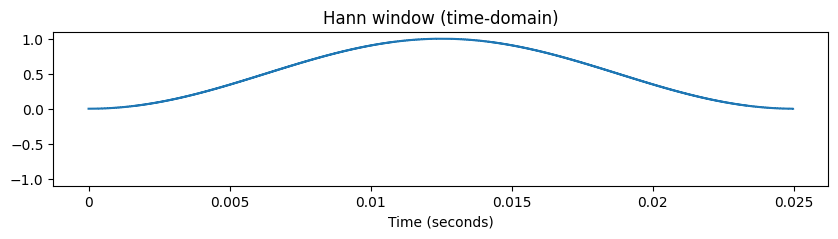

In [12]:
wav_plot(window.squeeze().numpy(), sr, listen=False, title="Hann window (time-domain)")

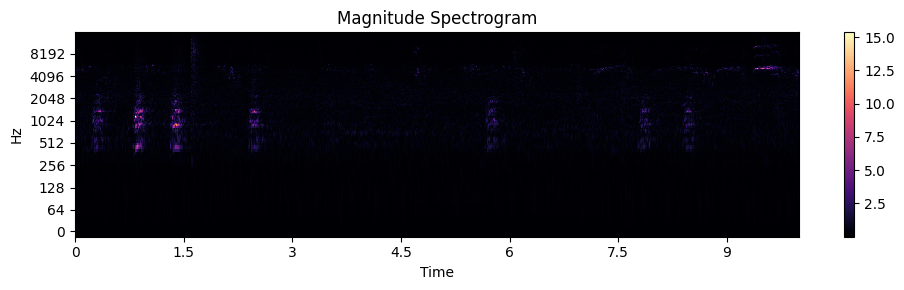

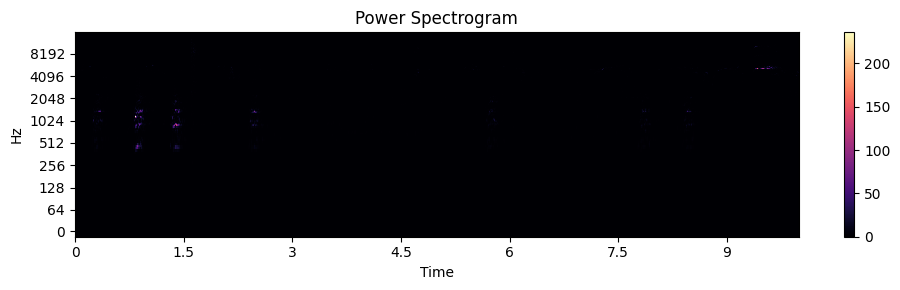

In [13]:
spec_liro(mag_spec.squeeze().numpy(), sr, x_is_spec=True, convert_to_db=False, title="Magnitude Spectrogram")
spec_liro(power_spec.squeeze().numpy(), sr, x_is_power_spec=True, convert_to_db=False, title="Power Spectrogram")

## Mel Transformation

In [14]:
n_mels, fmin, fmax = 40, 0.0, sr // 2
mel_basis = torchaudio.functional.melscale_fbanks(
    n_fft // 2 + 1, fmin, fmax, n_mels, sr
)
mel_basis = mel_basis.T
print(mel_basis.shape)

torch.Size([40, 513])


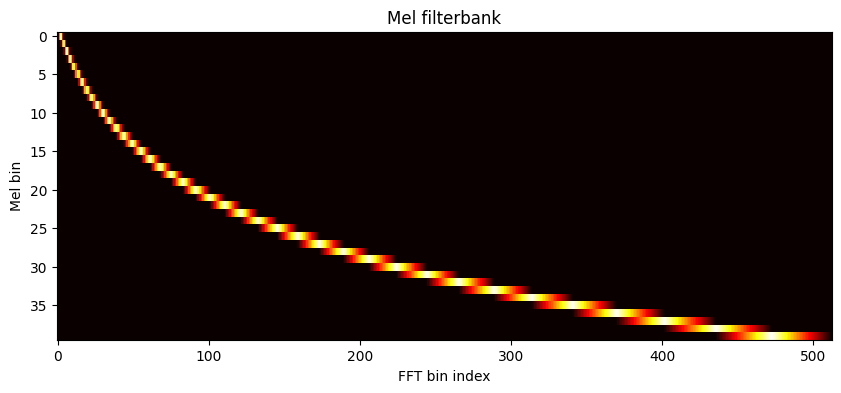

In [15]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 4))
ax.set_title("Mel filterbank")
ax.set_xlabel("FFT bin index")
ax.set_ylabel("Mel bin")
ax.imshow(mel_basis.squeeze().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

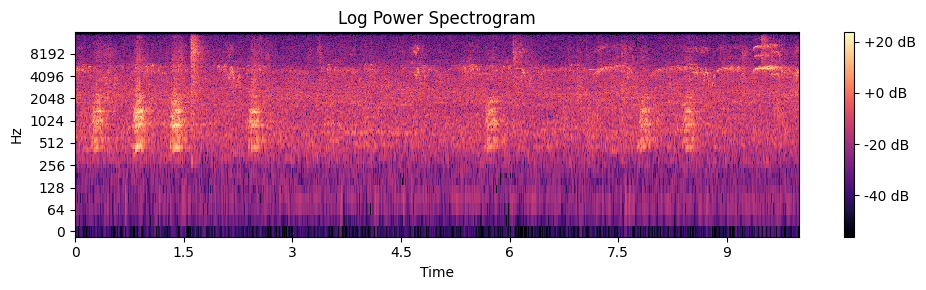

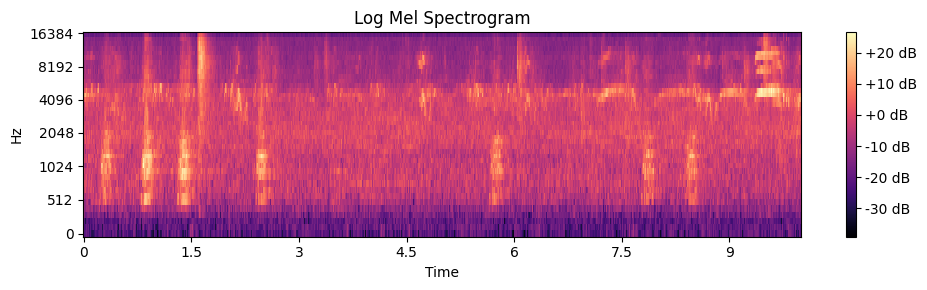

In [16]:
melspec = torch.matmul(mel_basis, power_spec)
spec_liro(power_spec.squeeze().numpy(), sr, x_is_power_spec=True, title="Log Power Spectrogram")
spec_liro(melspec.squeeze().numpy(), sr, x_is_mel_spec=True, title="Log Mel Spectrogram")

## Log the Amplitude

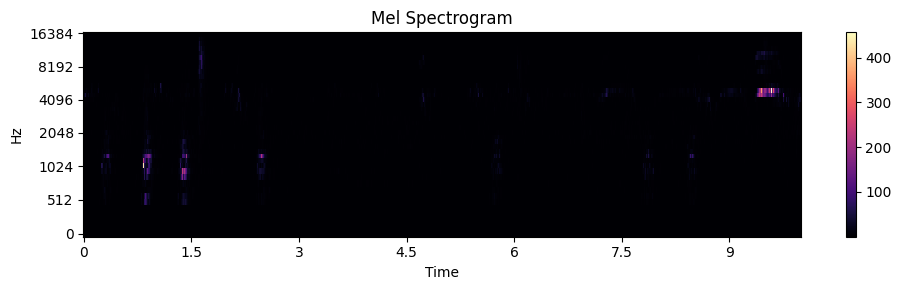

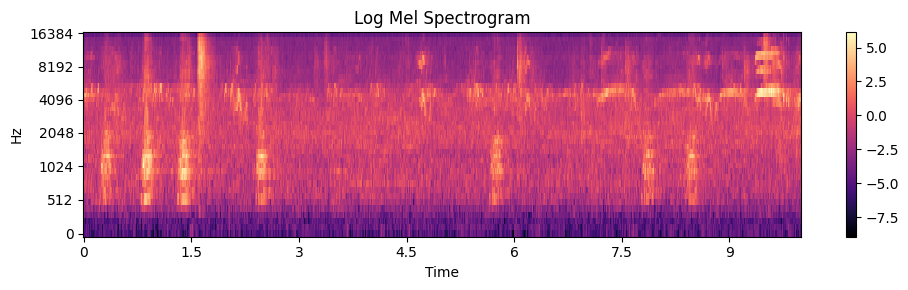

In [17]:
log_mel_spec = (melspec + 0.00001).log()
spec_liro(melspec.squeeze().numpy(), sr, x_is_mel_spec=True, convert_to_db=False, title="Mel Spectrogram")
spec_liro(log_mel_spec.squeeze().numpy(), sr, x_is_mel_spec=True, convert_to_db=False, title="Log Mel Spectrogram")

### What to do with a log mel spectrogram?

**Use your favorite vision architecture and treat the log mel spectrogram as an image with a single input channel.**

# Example Pipeline on GitHub

The <a href=https://github.com/fschmid56/malach24> example ML4Audio pipeline </a> demonstrates the following points based on 200 wav files:

* Dataset loading, PyTorch Dataset class, PyTorch Dataloader
* Audio Signal processing routine that we discussed today
* How to use a PyTorch Model (CNN) to generate predictions based on a log mel spectrogram
* Simple data augmentation techniques (masking time frames, masking frequency bands, mixup, time rolling)
* A training loop implemented with <a href=https://lightning.ai/>Pytorch Lightning</a>
* Logging implemented with <a href=https://wandb.ai/site>Weights and Biases</a>
* **Some** of the best practices we discussed

# Your next tasks

## Until 02.04.25 (one week) 

Prepare a **short presentation** (**10 minutes**) introducing the **baseline system** for your task.

* The **baseline code** will be available **by the end of this week or early next week** for Tasks 1, 6, AES QVIM.
* For **Task 4**, the baseline may be released **sometime next week**. If your baseline is not yet available, prepare your presentation based on a relevant **related system**, and include the same key aspects listed on the next slides — as if it were your baseline.

## Until 02.04.25 (one week)

* Aspects to look into:
  * What **datasets** is the baseline trained on?
  * What kind of **input representation** is used (e.g., log-mel spectrogram, waveform)?
  * Are there any **data augmentation techniques** (e.g., mixup, SpecAugment, noise injection)?
  * What **neural network architecture** is used?
  * What **loss function** is used?
  * What **evaluation metric** is used?
  * On what **validation/test split** is performance reported?
  * How long does it take to reproduce the baseline system?
  * Are there any **class imbalances** or **domain shifts** the baseline does handle (or not)?
  * What **optimizer** and **learning rate schedule**?
  * What are the **key hyperparameters** (batch size, learning rate, etc.)?
  * How far is it from the SOTA?

## Until 09.04.25 (two weeks) 

* Prepare a presentation (15 minutes). 
* Successfully reproduce the baseline results and show us the logged metrics.
  * Let us know **soon** if you encounter any problems.
* Tell us about your plans for improving the baseline over the easter break.

# Presentations